In [1]:
###IMPORTING LIBRARIES

import pandas as pd
import numpy as np

import random 

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN

#from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Define some plotting functions for later use

import seaborn as sn
import matplotlib.pyplot as plt

def plot_cm(tn,fp,fn,tp,name='LOGISTICS'):
    df_cm = pd.DataFrame([[tn, fp], [fn, tp]], index = [i for i in ["non-spam","spam"]],
                      columns = [j for j in ["non-spam","spam"]])
    plt.figure(figsize = (5,4))
    plt.title("Confusion Matrix : {}".format(name))
    sn.heatmap(df_cm, annot=True)
    

def plot_roc(y_test, probs,name='LOGISTICS'):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    #figure, axis = plt.subplots(1, 1)
    plt.figure(figsize = (4,4))
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve : {}".format(name))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()


In [54]:
#READING FILES
train_transaction = pd.read_csv('train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('train_identity.csv', index_col='TransactionID')
test_transaction = pd.read_csv('test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('test_identity.csv', index_col='TransactionID')

In [55]:
#JOINING/MERGING FILES
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(f'Shape of train set: {train.shape}')
print(f'Shape of test set: {test.shape}')

Shape of train set: (590540, 433)
Shape of test set: (506691, 432)


In [5]:
print(f'Number of fraud samples in train: {len(np.where(train["isFraud"]==1)[0])}')
print(f'Percent of fraud samples in train: {round(100.0*len(np.where(train["isFraud"]==1)[0])/len(train["isFraud"]),2)}')

Number of fraud samples in train: 20663
Percent of fraud samples in train: 3.5


In [25]:
#TAKE 10% OF TRAIN DATA ONLY. Since there are too much data 
#train = train.sample(frac=0.1, random_state=42) 
#train.reset_index(drop=True, inplace=True)
#train.head()

In [56]:
not_fraud=train[train.isFraud==0]
fraud=train[train.isFraud==1]

In [57]:
from sklearn.utils import resample

#DOING DOWNSAMPLING to make (# of nonspam data = # of spam data)
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
train = pd.concat([not_fraud_downsampled, fraud])

# checking counts
train.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

In [9]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3565834,0,15427537,55.000,W,13307,428.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3244029,0,6150574,97.000,W,6492,128.0,150.0,visa,195.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2993870,0,231776,84.588,C,9300,103.0,185.0,visa,138.0,debit,...,ie 11.0 for desktop,NaN,NaN,NaN,F,T,F,T,desktop,Trident/7.0
2991985,0,171531,159.950,W,15629,420.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3538080,0,14569477,15.000,H,16000,555.0,150.0,visa,226.0,debit,...,mobile safari 11.0,32.0,2436x1125,match_status:1,T,F,T,T,mobile,iOS Device


In [58]:
y = train.isFraud.values

In [59]:
#Just fill -1 for NaN, since there are too much features to handle one-by-one
train = train.drop('isFraud', axis=1)
test = test.copy()
train = train.fillna(-1) 
test = test.fillna(-1) 
del train_transaction, train_identity, test_transaction, test_identity

In [12]:
#Note now NaN filled with -1
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3565834,15427537,55.000,W,13307,428.0,150.0,visa,166.0,debit,325.0,...,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1
3244029,6150574,97.000,W,6492,128.0,150.0,visa,195.0,debit,264.0,...,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1
2993870,231776,84.588,C,9300,103.0,185.0,visa,138.0,debit,-1.0,...,ie 11.0 for desktop,-1.0,-1,-1,F,T,F,T,desktop,Trident/7.0
2991985,171531,159.950,W,15629,420.0,150.0,mastercard,224.0,debit,315.0,...,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1
3538080,14569477,15.000,H,16000,555.0,150.0,visa,226.0,debit,251.0,...,mobile safari 11.0,32.0,2436x1125,match_status:1,T,F,T,T,mobile,iOS Device


In [60]:
#Do Preprocessing for Categorical features. Do this with sklearn.preprocessing
for f in train.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  

In [14]:
#Note now Categorical values converted to numericals
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3565834,15427537,55.000,4,13307,428.0,150.0,4,166.0,3,325.0,...,0,-1.0,0,0,0,0,0,0,0,0
3244029,6150574,97.000,4,6492,128.0,150.0,4,195.0,3,264.0,...,0,-1.0,0,0,0,0,0,0,0,0
2993870,231776,84.588,0,9300,103.0,185.0,4,138.0,3,-1.0,...,114,-1.0,0,0,1,2,1,2,1,2086
2991985,171531,159.950,4,15629,420.0,150.0,3,224.0,3,315.0,...,0,-1.0,0,0,0,0,0,0,0,0
3538080,14569477,15.000,1,16000,555.0,150.0,4,226.0,3,251.0,...,118,32.0,256,2,2,1,2,2,2,2272


In [61]:
#Use Scaler function to normalize all feature values
cols = list(train.columns)
scaler = StandardScaler() 

train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

In [16]:
#Note that all features are normalized
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3565834,1.740485,-0.376490,0.774030,0.737077,0.425642,-0.428401,0.652376,-0.598043,0.744674,0.667911,...,-0.661050,-0.415100,-0.347525,-0.414845,-0.723760,-0.775292,-0.764103,-0.724007,-0.726998,-0.616733
3244029,-0.309935,-0.192351,0.774030,-0.668493,-1.400780,-0.428401,0.652376,0.018828,0.744674,0.270178,...,-0.661050,-0.415100,-0.347525,-0.414845,-0.723760,-0.775292,-0.764103,-0.724007,-0.726998,-0.616733
2993870,-1.618124,-0.246768,-1.524711,-0.089353,-1.552982,1.632543,0.652376,-1.193643,0.744674,-1.457679,...,2.088551,-0.415100,-0.347525,-0.414845,0.624514,3.119641,0.330242,1.959068,0.555944,1.720288
2991985,-1.631439,0.083639,0.774030,1.215981,0.376937,-0.428401,-0.966168,0.635699,0.744674,0.602709,...,-0.661050,-0.415100,-0.347525,-0.414845,-0.723760,-0.775292,-0.764103,-0.724007,-0.726998,-0.616733
3538080,1.550834,-0.551861,-0.950026,1.292499,1.198827,-0.428401,0.652376,0.678242,0.744674,0.185415,...,2.185029,2.831493,3.681605,1.603745,1.972789,1.172174,1.424587,1.959068,1.838886,1.928670


In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [64]:
lda = LDA()
X = lda.fit_transform(train[cols], y)  

In [31]:
#Perform dimensionality reduction by PCA. Use 100 dimensions
N = 100

pca = PCA(n_components=N, random_state=43)
X = pca.fit_transform(train[cols], y)  
pca.explained_variance_ratio_.sum()
#Using n=50 gives about 0.89, we wanted to use n with explained variance > 95%

0.9634477746168039

1 ROC AUC: 0.85805
Truth Positive: 3155
False Positive: 901
Truth Negative: 3232
False Negative: 978
Accuracy: 0.7726832809097508
F1 Score: 0.7705458541946514

2 ROC AUC: 0.86229
Truth Positive: 3150
False Positive: 824
Truth Negative: 3309
False Negative: 983
Accuracy: 0.7813936607790951
F1 Score: 0.777106204514617

3 ROC AUC: 0.85086
Truth Positive: 3102
False Positive: 853
Truth Negative: 3280
False Negative: 1031
Accuracy: 0.7720783934188241
F1 Score: 0.7670623145400594

4 ROC AUC: 0.85921
Truth Positive: 3135
False Positive: 851
Truth Negative: 3281
False Negative: 997
Accuracy: 0.7763794772507261
F1 Score: 0.7723577235772358

5 ROC AUC: 0.86182
Truth Positive: 3174
False Positive: 875
Truth Negative: 3257
False Negative: 958
Accuracy: 0.7781945788964182
F1 Score: 0.7759442610927759



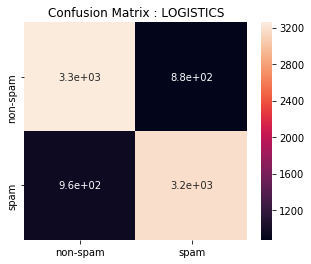

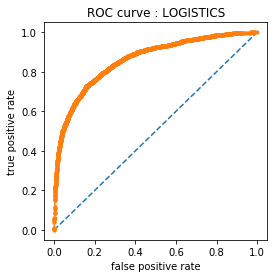

In [65]:
#Logistic Regression

from sklearn.metrics import f1_score 
#5-Folds Cross Validation, ensure similar ratio of spam:non-spam
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "reg"

train[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    reg = LR(solver="newton-cg", n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = reg.predict_proba(X_valid)[:,1]
    lab_pred = reg.predict(X_valid)
    #train.loc[valid_index, arch] = y_pred
    
    print(i+1, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    tn, fp, fn, tp = confusion_matrix(y_valid, lab_pred).ravel()
    print("Truth Positive:",tp)
    print("False Positive:",fp)
    print("Truth Negative:",tn)
    print("False Negative:",fn)
    print("Accuracy:", reg.score(X_valid,y_valid))
    print("F1 Score:", f1_score(lab_pred,y_valid))
    print()
    
#Plot confusion matrix for Logistics
plot_cm(tn,fp,fn,tp)

#Plot roc graph for Logistics
plot_roc(y_valid, y_pred) #fpr vs tpr

1 ROC AUC: 0.79289
Truth Positive: 2885
False Positive: 1229
Truth Negative: 2904
False Negative: 1248
Accuracy: 0.700338736994919
F1 Score: 0.6996483569782952

2 ROC AUC: 0.7878
Truth Positive: 2873
False Positive: 1247
Truth Negative: 2886
False Negative: 1260
Accuracy: 0.6967094120493588
F1 Score: 0.6962316733309099

3 ROC AUC: 0.78399
Truth Positive: 2834
False Positive: 1230
Truth Negative: 2903
False Negative: 1299
Accuracy: 0.6940479070892814
F1 Score: 0.6914724899353422

4 ROC AUC: 0.78567
Truth Positive: 2885
False Positive: 1284
Truth Negative: 2848
False Negative: 1247
Accuracy: 0.6937318489835431
F1 Score: 0.6950969762679196

5 ROC AUC: 0.79006
Truth Positive: 2883
False Positive: 1285
Truth Negative: 2847
False Negative: 1249
Accuracy: 0.6933688286544046
F1 Score: 0.694698795180723



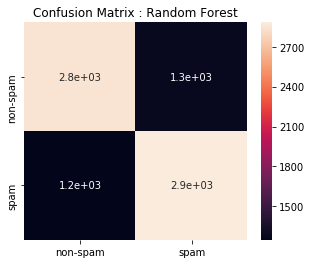

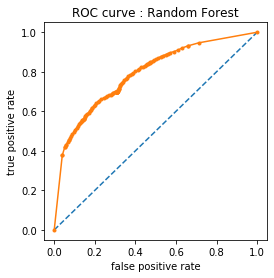

In [45]:
#Random Forest

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "rfc"

train[arch] = 0
test[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    rfc = RF(n_estimators=100, n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = rfc.predict_proba(X_valid)[:,1]
    lab_pred = rfc.predict(X_valid)
    #train.loc[valid_index, arch] = y_pred
    
    print(i+1, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    tn, fp, fn, tp = confusion_matrix(y_valid, lab_pred).ravel()
    print("Truth Positive:",tp)
    print("False Positive:",fp)
    print("Truth Negative:",tn)
    print("False Negative:",fn)
    print("Accuracy:", rfc.score(X_valid,y_valid))
    print("F1 Score:", f1_score(lab_pred,y_valid))
    print()
plot_cm(tn,fp,fn,tp, "Random Forest")
plot_roc(y_valid, y_pred, "Random Forest") #fpr vs tpr

1 ROC AUC: 0.81001
Truth Positive: 3024
False Positive: 977
Truth Negative: 3156
False Negative: 1109
Accuracy: 0.747640938785386
F1 Score: 0.7435456110154907

2 ROC AUC: 0.80715
Truth Positive: 3009
False Positive: 973
Truth Negative: 3160
False Negative: 1124
Accuracy: 0.7463101863053472
F1 Score: 0.7415896487985212

3 ROC AUC: 0.80489
Truth Positive: 2972
False Positive: 952
Truth Negative: 3181
False Negative: 1161
Accuracy: 0.7443745463343818
F1 Score: 0.7377435770137768

4 ROC AUC: 0.80352
Truth Positive: 2988
False Positive: 1006
Truth Negative: 3126
False Negative: 1144
Accuracy: 0.739835430784124
F1 Score: 0.7354171794240708

5 ROC AUC: 0.81296
Truth Positive: 3026
False Positive: 954
Truth Negative: 3178
False Negative: 1106
Accuracy: 0.7507260406582769
F1 Score: 0.7460552268244576



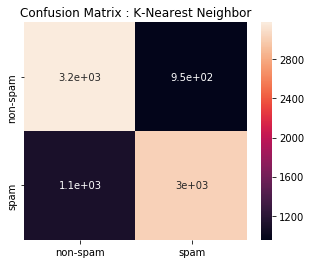

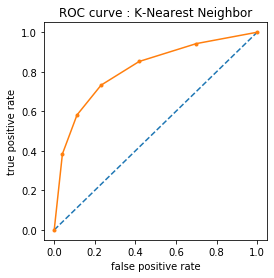

In [47]:
#KNN

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "knn"

train[arch] = 0
test[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    knn = KNN(n_neighbors=5, weights='uniform').fit(X_train, y_train) 
    
    y_pred = knn.predict_proba(X_valid)[:,1]
    lab_pred = knn.predict(X_valid)
    #train.loc[valid_index, arch] = y_pred
    
    print(i+1, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    tn, fp, fn, tp = confusion_matrix(y_valid, lab_pred).ravel()
    print("Truth Positive:",tp)
    print("False Positive:",fp)
    print("Truth Negative:",tn)
    print("False Negative:",fn)
    print("Accuracy:", knn.score(X_valid,y_valid))
    print("F1 Score:", f1_score(lab_pred,y_valid))
    print()
    
plot_cm(tn,fp,fn,tp, "K-Nearest Neighbor")
plot_roc(y_valid, y_pred, "K-Nearest Neighbor") #fpr vs tpr

1 ROC AUC: 0.8559
Truth Positive: 3006
False Positive: 724
Truth Negative: 3409
False Negative: 1127
Accuracy: 0.7760706508589402
F1 Score: 0.7645936665394887

2 ROC AUC: 0.86017
Truth Positive: 2859
False Positive: 550
Truth Negative: 3583
False Negative: 1274
Accuracy: 0.7793370433099444
F1 Score: 0.7581543357199682

3 ROC AUC: 0.84939
Truth Positive: 2833
False Positive: 637
Truth Negative: 3496
False Negative: 1300
Accuracy: 0.7656665860150013
F1 Score: 0.7452321452058397

4 ROC AUC: 0.85787
Truth Positive: 2949
False Positive: 669
Truth Negative: 3463
False Negative: 1183
Accuracy: 0.7758954501452081
F1 Score: 0.7610322580645161

5 ROC AUC: 0.86044
Truth Positive: 3038
False Positive: 710
Truth Negative: 3422
False Negative: 1094
Accuracy: 0.781703775411423
F1 Score: 0.7710659898477157



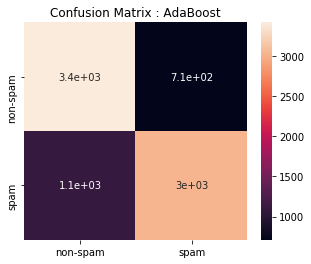

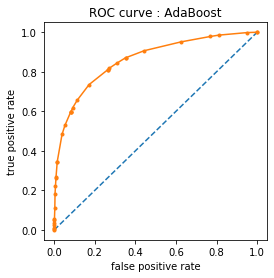

In [48]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier as abc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
arch = "adab"

train[arch] = 0
test[arch] = 0

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    adab = abc(n_estimators=50).fit(X_train, y_train) 
    
    y_pred = adab.predict_proba(X_valid)[:,1]
    lab_pred = adab.predict(X_valid)
    #train.loc[valid_index, arch] = y_pred
    
    print(i+1, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 5))
    tn, fp, fn, tp = confusion_matrix(y_valid, lab_pred).ravel()
    print("Truth Positive:",tp)
    print("False Positive:",fp)
    print("Truth Negative:",tn)
    print("False Negative:",fn)
    print("Accuracy:", adab.score(X_valid,y_valid))
    print("F1 Score:", f1_score(lab_pred,y_valid))
    print()

#Plot confusion matrix for adaboost
plot_cm(tn,fp,fn,tp, "AdaBoost")

#Plot roc graph for adaboost
plot_roc(y_valid, y_pred, "AdaBoost") #fpr vs tpr

In [22]:
"""
import time
from sklearn.manifold import TSNE

t0 = time.time()

new = np.append(X_train[0:1000], X_train[-1000:], axis=0)
new_y = np.append(y_train[0:1000], y_train[-1000:], axis=0)

X_reduced_tsne = TSNE(n_components=2).fit_transform(new)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2).fit_transform(new)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))
"""

'\nimport time\nfrom sklearn.manifold import TSNE\n\nt0 = time.time()\n\nnew = np.append(X_train[0:1000], X_train[-1000:], axis=0)\nnew_y = np.append(y_train[0:1000], y_train[-1000:], axis=0)\n\nX_reduced_tsne = TSNE(n_components=2).fit_transform(new)\nt1 = time.time()\nprint("T-SNE took {:.2} s".format(t1 - t0))\n\n# PCA Implementation\nt0 = time.time()\nX_reduced_pca = PCA(n_components=2).fit_transform(new)\nt1 = time.time()\nprint("PCA took {:.2} s".format(t1 - t0))\n'

In [23]:
"""

import matplotlib.patches as mpatches

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(new_y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(new_y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(new_y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(new_y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])
"""

"\n\nimport matplotlib.patches as mpatches\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))\n# labels = ['No Fraud', 'Fraud']\nf.suptitle('Clusters using Dimensionality Reduction', fontsize=14)\n\n\nblue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')\nred_patch = mpatches.Patch(color='#AF0000', label='Fraud')\n\n\n# t-SNE scatter plot\nax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(new_y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)\nax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(new_y == 1), cmap='coolwarm', label='Fraud', linewidths=2)\nax1.set_title('t-SNE', fontsize=14)\n\nax1.grid(True)\n\nax1.legend(handles=[blue_patch, red_patch])\n\n# PCA scatter plot\nax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(new_y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)\nax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(new_y == 1), cmap='coolwarm', label='Fraud', linewidths=2)\nax2.set_title('PCA', fontsize=14)\n\nax2.grid(True)\